In [155]:
# Load the "autoreload" extension so that code can change
# Always reload modules so that as soon as code changes in src, it gets automatically reloaded without kernel relaunch
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import sys
sys.path.append('../') 

from src.utils import datacollector
from src.utils import constants as cst

from src.visualization import visualization as viz
from src.visualization import query as q
from src.preprocessing import cleaning

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# REMINDER - OBJECTIVE
As a reminder, **our objective for modeling will be to be able to predict the price for a given listing**.  
We have seen that the price can be rather different depending on the period of the year. Of course, it can varies due to some other features, each one with its own importance. We have observed for example that the neighbourhood is one of them.  
To build something which will more reflect what happens in real life, I should merge the `listings.csv.gz` dataset with the `calendar.csv.gz` one but it will give me a too huge dataset with more than 20 millions of rows and hundred of features.  
**For computation reasons and as the goal of this project is more to validate an approach than building the perfectly perfect model, I choose to keep only the `listings.csv.gz` dataset and its 64K rows and my goal will be to try to predict the mean price for each element of the listing**.

In next sections below you will find all preliminary steps that are mandatory before starting the modeling phase.  
This will be based on what we have discovered during the [Data Understanding](1_Data_Understanding.ipynb) phase (see the 'summary' part for a reminder).

# 1. Load dataset & drop unnecessary features
The easiest thing to start with.

In [115]:
df_lst_full = pd.read_csv(datacollector.get_data_file(cst.LISTING_FULL_FILE), sep=',', header=0, low_memory=False)

In [116]:
cols_to_drop = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', 'notes', 'transit', 'interaction', 
                'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_name', 
                'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_since', 
                'host_location', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 
                'host_verifications', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'host_has_profile_pic', 
                'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
                'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'street', 
                'neighbourhood', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 
                'country_code', 'country', 'latitude', 'longitude', 'property_type', 'square_feet', 'has_availability', 
                'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review', 'requires_license', 
                'is_business_travel_ready', 'require_guest_profile_picture', 'require_guest_phone_verification']
df_lst_reduced = cleaning.drop_cols(df_lst_full, cols_to_drop)

After column dropping, new shape is now (64293, 50)


# 2. Features transformation
## 2.1. Text extraction or drop ?
I said in [Data Understanding](1_Data_Understanding.ipynb) conclusion that depending on the use case, perhaps we could try to extract some keywords from `name`, `summary`, `space`, `description`, `neighborhood_overview`, `access`.  
Idea is good and could be addressed with NLP packages, maint thing is those features contains text which is sometimes in french sometimes in english. That would add a non negligible amount of data so, for the moment, I propose to start with a simple approach and just drop those features.

In [117]:
txt_cols_to_drop = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'access']
df_lst_reduced_notxt = cleaning.drop_cols(df_lst_reduced, txt_cols_to_drop)

After column dropping, new shape is now (64293, 44)


## 2.2. From 't'/'f' to binary 0/1
Here we will deal with columns that contains the now famous "t/f" categorical nominal values.

In [118]:
tf_cols = ['host_is_superhost', 'host_identity_verified', 'is_location_exact', 'instant_bookable']

# Keep track of values before transformation so that we can check after that everything went as expected
check_dict = {}

# Transform each column and control
for feat in tf_cols:
    check_dict[feat] = df_lst_reduced_notxt[df_lst_reduced_notxt[feat] == 't'][feat].count()
    df_lst_reduced_notxt = cleaning.transform_t_f(df_lst_reduced_notxt, feat)
    
    assert check_dict[feat] == df_lst_reduced_notxt[feat].sum()
print("After transformation shape is still {}".format(df_lst_reduced_notxt.shape))

After transformation shape is still (64293, 44)


**Note:** the transformation for those features is not totally finished, **we will still have to handle missing values for some of them:**

In [119]:
for feat in tf_cols:
    print("Nb missing values for feature '{}' is {}".format(feat, df_lst_reduced_notxt[feat].isna().sum()))

Nb missing values for feature 'host_is_superhost' is 64
Nb missing values for feature 'host_identity_verified' is 64
Nb missing values for feature 'is_location_exact' is 0
Nb missing values for feature 'instant_bookable' is 0


We have also the `license` feature to deal with. It is not a "t/f" column but after the _data discovery_ phase the decision was to create a new binary feature which will stand for 'license missing yes/no'. Let's do that.

In [120]:
df_lst_reduced_notxt['license_missing'] = df_lst_reduced_notxt['license'].apply(lambda x: 1 if pd.isnull(x) else 0)
assert df_lst_reduced_notxt['license_missing'].sum() == df_lst_reduced_notxt['license'].isna().sum()
# Do not forget to remove the old column which is now useless
df_lst_reduced_notxt = cleaning.drop_cols(df_lst_reduced_notxt, ['license'])

After column dropping, new shape is now (64293, 44)


## 2.3. Handle 'currency' columns
For columns with 'currency' elements ('price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people') we will remove currency symbol and handle the thousands separator. In the end we convert to float.

In [121]:
currency_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
df_lst_reduced_notxt_currok = cleaning.clean_currency_columns(df_lst_reduced_notxt, currency_cols)

In [122]:
for feat in currency_cols:
    print("Nb missing values for feature '{}' is {}".format(feat, df_lst_reduced_notxt_currok[feat].isna().sum()))

Nb missing values for feature 'price' is 0
Nb missing values for feature 'weekly_price' is 53899
Nb missing values for feature 'monthly_price' is 57694
Nb missing values for feature 'security_deposit' is 19852
Nb missing values for feature 'cleaning_fee' is 17191
Nb missing values for feature 'extra_people' is 0


After new considerations **regarding the number of missing values I decide to also drop `weekly_price` and `monthly_price`**.  With very few missing values, perhaps it would have helped us to predict a mean price but here imputation will lead us with really strange results so I prefer to get rid of those features. I should have seen that before but late is better than never so...  
`cleaning_fee` and `security_deposit` will have to be handled later with kind of imputation.

In [123]:
df_lst_reduced_notxt_currok = cleaning.drop_cols(df_lst_reduced_notxt_currok, ['weekly_price', 'monthly_price'])

After column dropping, new shape is now (64293, 42)


## 2.4. One-hot encoding of categorical features
`neighbourhood_cleansed`, `room_type`, `bed_type` and `cancellation_policy` are the features chosen for this kind of transformation.

In [124]:
one_hot_cols = ['neighbourhood_cleansed', 'room_type', 'bed_type', 'cancellation_policy']
for feat in one_hot_cols:
    print("Nb missing values for feature '{}' is {}".format(feat, df_lst_reduced_notxt_currok[feat].isna().sum()))
df_lst_reduced_notxt_currok_dummies = cleaning.encode_categorical(df_lst_reduced_notxt_currok, one_hot_cols)

Nb missing values for feature 'neighbourhood_cleansed' is 0
Nb missing values for feature 'room_type' is 0
Nb missing values for feature 'bed_type' is 0
Nb missing values for feature 'cancellation_policy' is 1
After one-hot encoding, new shape is now (64293, 72)


## 2.5 Handle 'jurisdiction_names' feature

In [125]:
df_lst_reduced_notxt_currok_dummies.jurisdiction_names.value_counts()

{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," PARIS"}                                                                           62850
{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"}                                                                                      767
{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," BOULOGNE BILLANCOURT"}                                                               77
{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," NEUILLY SUR SEINE"}                                                                  55
{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," ISSY LES MOULINEAUX"}                                                                52
{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," LEVALLOIS PERRET"}                                                                   50
{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_

All well considered, after transformation 98% of the dataset will have _'Paris'_ as value. The 2nd value will be something like _'None'_ (767 rows) so it will not help us. **In the end I choose to drop this feature.**

In [126]:
df_lst_reduced_notxt_currok_dummies = cleaning.drop_cols(df_lst_reduced_notxt_currok_dummies, ['jurisdiction_names'])

After column dropping, new shape is now (64293, 71)


## 2.6 Last but not least, 'amenities' management
For this feature we will extract useful information and depending on the number of distinct values, perform 1-hot encoding over the values

In [127]:
df_lst_reduced_notxt_currok_dummies.amenities.value_counts()[:10]

{}                                                                                                                                                                                                                                                   181
{TV,"Cable TV",Wifi,Kitchen,Heating,"Family/kid friendly",Washer,"Smoke detector",Hangers,"Hair dryer",Iron,"Laptop friendly workspace"}                                                                                                              52
{TV,Wifi,Kitchen,Heating,Washer,"Smoke detector",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Private entrance","Hot water","Bed linens"}                                                                                34
{Internet,Wifi,Kitchen,Heating,Essentials}                                                                                                                                                                                                            31
{TV,

In [128]:
df_lst_reduced_notxt_currok_dummies.amenities.isna().sum()

0

Good point is that **there is no missing value** (actually they are _replaced_ with '{}'). Now I will remove the leading '{' and '}' characters. And remove also the '"' punctuation.  
I will then handle the multiple values transformation to dummies with this [helpful link from stackoverflow](https://stackoverflow.com/questions/18889588/create-dummies-from-column-with-multiple-values-in-pandas).

In [129]:
df_lst_reduced_notxt_currok_dummies.amenities = df_lst_reduced_notxt_currok_dummies.amenities.str.strip('{}')
df_lst_reduced_notxt_currok_dummies.amenities = df_lst_reduced_notxt_currok_dummies.amenities.str.replace('"', '')

In [130]:
df_only_amenities = df_lst_reduced_notxt_currok_dummies.amenities
df_only_amenities = df_only_amenities.str.get_dummies(sep=',')

In [131]:
df_only_amenities.head()

,toilet,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,Alfresco bathtub,Amazon Echo,BBQ grill,Baby bath,...,Wide doorway to guest bathroom,Wide entrance,Wide entrance for guests,Wide entryway,Wide hallways,Wifi,Window guards,Wine cooler,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Wow 182 columns that's a lot !  
**Notes:**
* there are at least 2 translations missing, will it matter ?
* in what has been transformed the empty initial amenities value '{}' ?

In [132]:
print(df_only_amenities.columns.tolist(), end='')

[' toilet', '24-hour check-in', 'Accessible-height bed', 'Accessible-height toilet', 'Air conditioning', 'Air purifier', 'Alfresco bathtub', 'Amazon Echo', 'BBQ grill', 'Baby bath', 'Baby monitor', 'Babysitter recommendations', 'Balcony', 'Bath towel', 'Bathroom essentials', 'Bathtub', 'Bathtub with bath chair', 'Beach essentials', 'Beach view', 'Beachfront', 'Bed linens', 'Bedroom comforts', 'Bidet', 'Body soap', 'Breakfast', 'Breakfast table', 'Building staff', 'Buzzer/wireless intercom', 'Cable TV', 'Carbon monoxide detector', 'Cat(s)', 'Ceiling fan', 'Ceiling hoist', 'Central air conditioning', 'Changing table', 'Children’s books and toys', 'Children’s dinnerware', 'Cleaning before checkout', 'Coffee maker', 'Convection oven', 'Cooking basics', 'Crib', 'DVD player', 'Day bed', 'Disabled parking spot', 'Dishes and silverware', 'Dishwasher', 'Dog(s)', 'Doorman', 'Double oven', 'Dryer', 'EV charger', 'Electric profiling bed', 'Elevator', 'En suite bathroom', 'Espresso machine', 'Essen

As 182 new columns is a lot, I will check if there are amenities with few occurrences.

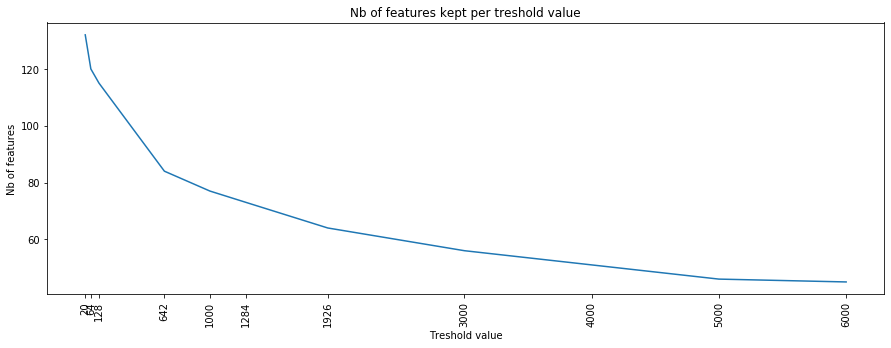

In [133]:
df_amen_sum = viz.plot_amenities_nb_features_and_tresholds(df_only_amenities)

Here we are not choosing the number of clusters with 'elbow' method but the approach is similar: ***we are looking for a specific value (threshold) that would reduce our number of new amenities features in a smart way***. For that we count the number of listings containing each amenity and we plot the number of features that would be kept if the treshold were this or this value.  
For instance, here we can see that **with a treshold of 642 we keep around 80 features, that's almost 100 less !**  
Note that 642 in this case represents 1% of the total number of listings so it's not bad at all: dropping the more or less 100 hundred features would impact less than 1% of the listings. The more we increase the treshold value the less we 'gain' in feature dropping (it is around 70 features for 2%). Let's keep the 1%.

In [134]:
# Let's see what it looks like
df_amen_sum[df_amen_sum['amen_sum'] < 642].head(7)

,amen_sum
toilet,346
Accessible-height bed,257
Accessible-height toilet,221
Air purifier,3
Alfresco bathtub,1
Amazon Echo,3
BBQ grill,225


In [135]:
df_only_amenities_reduced = cleaning.drop_cols(df_only_amenities, df_amen_sum[df_amen_sum['amen_sum'] < 642].index.tolist())

After column dropping, new shape is now (64293, 84)


In [136]:
# We're almost there, just concat and drop the original 'amenities' column
df_almost_clean = pd.concat([df_lst_reduced_notxt_currok_dummies, df_only_amenities_reduced], axis=1)
assert df_almost_clean.shape[1] == df_lst_reduced_notxt_currok_dummies.shape[1] + df_only_amenities_reduced.shape[1]
assert df_almost_clean.shape[0] == df_lst_reduced_notxt_currok_dummies.shape[0]
df_almost_clean = cleaning.drop_cols(df_almost_clean, ['amenities'])

After column dropping, new shape is now (64293, 154)


## 2.7. So now we can handle rows with missing values
### Split train-val-test
Because the next step involves imputation or creation of new columns to indicate when value is missing, it is time to proceed to train/test split. Why ? See this [reference](https://stats.stackexchange.com/questions/95083/imputation-before-or-after-splitting-into-train-and-test):
>"The division between training and test set is an attempt to replicate the situation where you have past information and are building a model which you will test on future as-yet unknown information: the training set takes the place of the past and the test set takes the place of the future, so you only get to test your trained model once.  
Keeping the past/future analogy in mind, this means anything you do to pre-process or process your data, such as imputing missing values, you should do on the training set alone. You can then remember what you did to your training set if your test set also needs pre-processing or imputing, so that you do it the same way on both sets."

But before doing that let's save what we have done so far so that we do not have to run it again. To ease the use, I have created a single `clean` function that takes the whole dataset as input and:
* drop unnecessary columns
* encode categorical to dummies 0/1
* transform binary nominal to binary numeric 0/1*
* handle currency symbols
* extract amenities and dummies

In [137]:
# Whole cleaning in a single call + check the shape
df_clean = cleaning.clean_listings(df_lst_full)
assert df_clean.shape[0] == df_almost_clean.shape[0]
assert df_clean.shape[1] == df_almost_clean.shape[1]

After column dropping, new shape is now (64293, 41)
After one-hot encoding, new shape is now (64293, 72)
After column dropping, new shape is now (64293, 84)
After column dropping, new shape is now (64293, 154)


#### Split into train, val and test

In [138]:
# Define X and Y
X = df_clean.drop(['price'], axis=1)
y = df_clean['price']

# Split train-test split with 10% for test and 90% for train + val
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
# Do it again with still 10% for validation and 90% for train
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42, shuffle=True)

# Show number of rows for each
print("X_train and y_train have respectively {} and {} rows".format(X_train.shape[0], y_train.shape[0]))
print("X_val and y_val have respectively {} and {} rows".format(X_val.shape[0], y_val.shape[0]))
print("X_test and y_test have respectively {} and {} rows".format(X_test.shape[0], y_test.shape[0]))

X_train and y_train have respectively 52076 and 52076 rows
X_val and y_val have respectively 5787 and 5787 rows
X_test and y_test have respectively 6430 and 6430 rows


### Analyze missing for imputation decision
Let's first analyze what we are concretely talking about by printing basic informations for each feature with at least one missing value in any row of the dataset.

In [139]:
for feat in X_train.columns[X_train.isnull().any()].tolist():
    q.print_basic_info_for_feature(X_train, feat)
    print("=========================================================\n")

There are 2 different values for the 'host_is_superhost' feature.
There are 54 missing values (0.10%).
Here is a sample:
[ 1.  0. nan]

There are 2 different values for the 'host_identity_verified' feature.
There are 54 missing values (0.10%).
Here is a sample:
[ 0.  1. nan]

There are 17 different values for the 'bathrooms' feature.
There are 51 missing values (0.10%).
Here is a sample:
[1.  1.5 2.  2.5 3.  4.  0.  3.5]

There are 13 different values for the 'bedrooms' feature.
There are 38 missing values (0.07%).
Here is a sample:
[ 1.  2.  0.  3.  5.  4. 10.  6.]

There are 19 different values for the 'beds' feature.
There are 385 missing values (0.74%).
Here is a sample:
[ 1.  4.  2. nan  3.  6.  7.  5.]

There are 479 different values for the 'security_deposit' feature.
There are 16144 missing values (31.00%).
Here is a sample:
[  nan 1200.  800.    0.  300. 1106. 3000.  600.]

There are 189 different values for the 'cleaning_fee' feature.
There are 13934 missing values (26.76%).


### 2.7.1. 'host_is_superhost' & 'host_identity_verified'

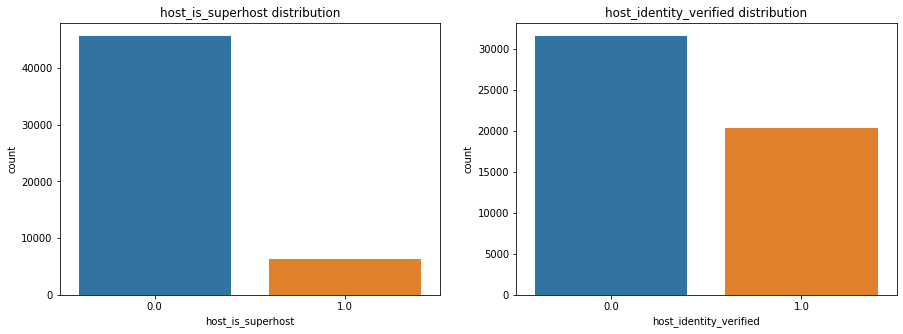

In [140]:
viz.countplot_for_imputation(X_train, ['host_is_superhost', 'host_identity_verified'])

**Imputation decision:** replace missing values in both features with mode value (0).

### 2.7.2. 'bathrooms', 'bedrooms' & 'beds'

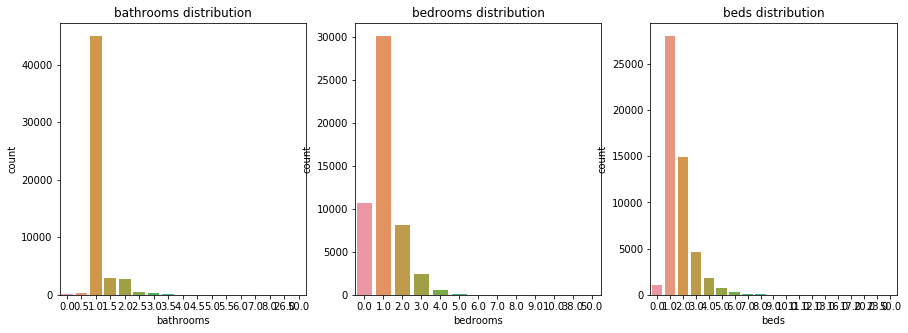

In [141]:
viz.countplot_for_imputation(X_train, ['bathrooms', 'bedrooms', 'beds'])

**Imputation decision:** replace missing values in both features with mode value (1).

### 2.7.3. 'security_deposit' & 'cleaning_fee'

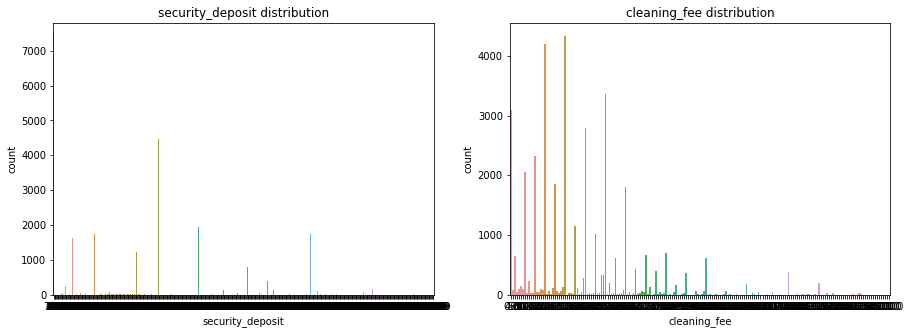

In [142]:
viz.countplot_for_imputation(X_train, ['security_deposit', 'cleaning_fee'])

Not so easy to decide with those plots. Let's analyze statistics data.

In [143]:
X_train[['security_deposit', 'cleaning_fee']].describe()

,security_deposit,cleaning_fee
count,35932.000000,38142.000000
mean,400.304993,39.139767
std,525.738838,35.055517
min,0.000000,0.000000
25%,100.000000,20.000000
50%,300.000000,30.000000
75%,500.000000,50.000000
max,4740.000000,700.000000


For the `cleaning_fee` feature I will take the mean but for `security_deposit` there is high variance, I am more willing to take the mode.

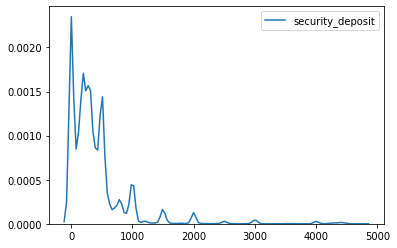

In [154]:
sns.kdeplot(X_train['security_deposit'])

In [145]:
X_train['security_deposit'].value_counts()

0.0       7418
500.0     4733
300.0     4469
200.0     3282
400.0     1943
          ... 
157.0        1
2121.0       1
4375.0       1
286.0        1
1050.0       1
Name: security_deposit, Length: 479, dtype: int64

Few values have also the same number of occurrences. 500€ could be a good one (we have seen that 75% of the listings are under this value).  
**Imputation decisions:**
* Replace `cleaning_fee` missing values with the mean value.
* Let's go with 500€ for missing values in `security_deposit`.

### 2.7.4. Reviews
#### The 6 reviews different values

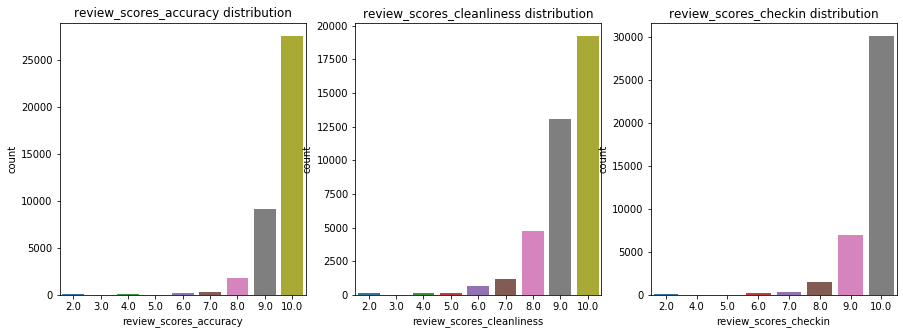

In [146]:
viz.countplot_for_imputation(X_train, ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin'])

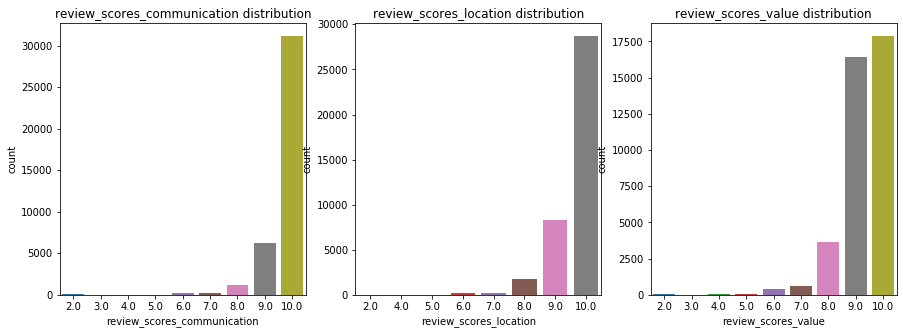

In [147]:
viz.countplot_for_imputation(X_train, ['review_scores_communication', 'review_scores_location', 'review_scores_value'])

**Imputation decision:** let's replace with 10 (mode), it will just emphase a little bit more this most frequent value.

#### The overall review score

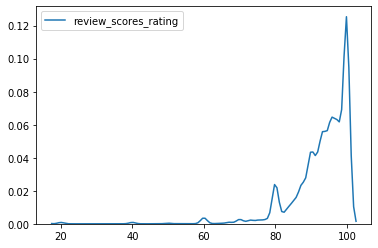

In [148]:
sns.kdeplot(X_train['review_scores_rating'])

In [149]:
X_train['review_scores_rating'].value_counts().head(8)

100.0    9521
93.0     2700
96.0     2612
97.0     2544
95.0     2472
90.0     2467
98.0     2446
80.0     1999
Name: review_scores_rating, dtype: int64

**Imputation decision:** if we take '10' to the 6 others, let's take 100 for this one.

#### The reviews per month
There are 913 different values for the 'reviews_per_month' feature.  
There are 14609 missing values (22.72%).  

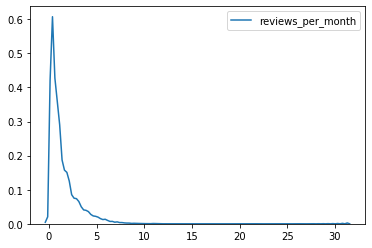

In [150]:
sns.kdeplot(X_train['reviews_per_month'])

In [151]:
X_train['reviews_per_month'].value_counts().head(8)

1.00    1154
0.02     724
0.08     699
0.03     697
0.04     658
0.05     644
0.06     548
2.00     531
Name: reviews_per_month, dtype: int64

In [152]:
X_train['reviews_per_month'].describe()

count    40187.000000
mean         1.213178
std          1.469266
min          0.010000
25%          0.230000
50%          0.700000
75%          1.640000
max         31.150000
Name: reviews_per_month, dtype: float64

**Imputation decision:** take the mean value (1.21) which is not so far than the mode and between median and 3rd quartile.

### Final word
**Data preparation** part is now over. Next part will be focus on **Modeling** (model choice, metric selection, evaluation, etc). As the feature transformation might differ from one model to another I suggest to stop the _data preparation_ phase here and save our cleaned datasets into a `clean` folder.

In [153]:
datacollector.save_listing_splits([X_train, y_train, X_val, y_val, X_test, y_test])

All files saved to ../data/clean folder


---

Now that everything has been saved, we can move forward with the most exciting part: **[Modeling !](4_Modeling.ipynb)**